<a href="https://colab.research.google.com/github/AryanGupta0419/PytorchTutorial/blob/main/DLLAB8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 150kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.69MB/s]


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
num_epochs = 5
train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)

    train_acc = 100 * correct_train / total_train
    train_acc_list.append(train_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")


    model.eval()
    correct_test, total_test, test_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_loss_list.append(avg_test_loss)

    test_acc = 100 * correct_test / total_test
    test_acc_list.append(test_acc)

    print(f"Test Accuracy: {test_acc:.2f}%")


Epoch [1/5] -> Train Loss: 0.1849, Train Acc: 94.56%
Test Accuracy: 98.26%
Epoch [2/5] -> Train Loss: 0.0551, Train Acc: 98.32%
Test Accuracy: 98.65%
Epoch [3/5] -> Train Loss: 0.0378, Train Acc: 98.85%
Test Accuracy: 98.86%
Epoch [4/5] -> Train Loss: 0.0289, Train Acc: 99.10%
Test Accuracy: 98.96%
Epoch [5/5] -> Train Loss: 0.0222, Train Acc: 99.31%
Test Accuracy: 99.04%


In [8]:
def visualize_filters(model):
    filters = model.conv1.weight.cpu().detach().numpy()
    fig, axes = plt.subplots(2, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(filters[i, 0], cmap='gray')
        ax.axis("off")
    plt.suptitle("Filters in First Convolution Layer")
    plt.show()


In [9]:
def visualize_feature_maps(model, images):
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        conv1_output = model.conv1(images)  # Get feature maps

    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(conv1_output[0, i].cpu().numpy(), cmap="gray")
        ax.axis("off")

    plt.suptitle("Feature Maps After First Convolution Layer")
    plt.show()

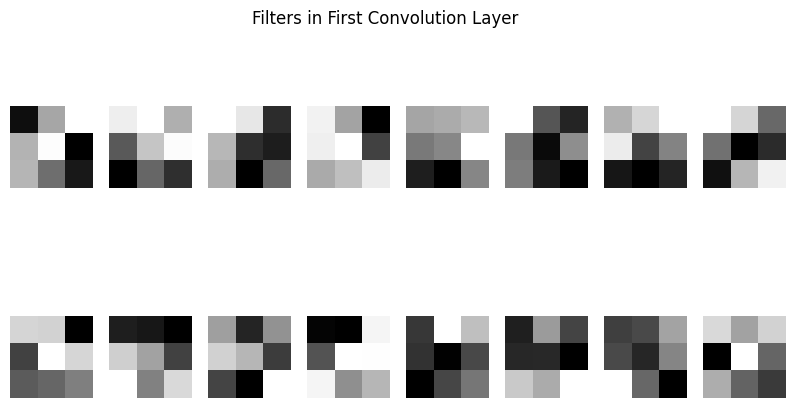

In [10]:
sample_images, _ = next(iter(test_loader))
visualize_filters(model)

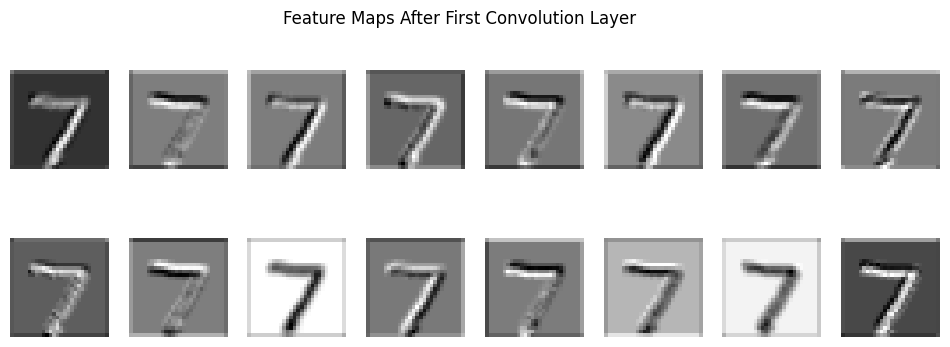

In [11]:
visualize_feature_maps(model, sample_images[:1])

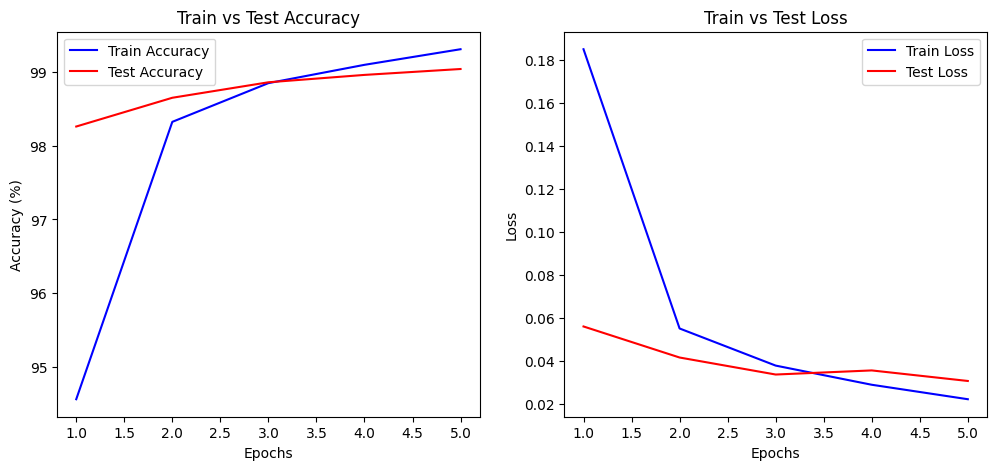

In [12]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_list, "b-", label="Train Accuracy")
plt.plot(epochs, test_acc_list, "r-", label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_list, "b-", label="Train Loss")
plt.plot(epochs, test_loss_list, "r-", label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()

plt.show()